In [126]:
from statsbombpy import sb
import json

In [6]:
comps = sb.competitions()
# comps[comps["competition_name"]=="Premier League"]
# comps.sort_values(by="season_name",ascending=False).head(10)
# comp_match_counts = {}
# for _, row in comps.sort_values(by="season_name",ascending=False).head(20).iterrows():
#     matches = sb.matches(row["competition_id"], row["season_id"])
#     comp_match_counts[f"{row['competition_name']} ({row['season_name']})"] = len(matches)
# comp_match_counts


NameError: name 'sb' is not defined

In [30]:
comps[comps["competition_name"]=="UEFA Euro"]
sb.matches(55, 282).head()


NameError: name 'comps' is not defined

In [28]:
comps[comps["competition_name"]=="Premier League"]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
64,2,27,England,Premier League,male,False,False,2015/2016,2024-06-12T07:43:56.243851,2021-06-13T16:17:31.694,None,2024-06-12T07:43:56.243851
65,2,44,England,Premier League,male,False,False,2003/2004,2024-03-08T14:49:13.195793,2021-06-13T16:17:31.694,None,2024-03-08T14:49:13.195793


In [64]:
print("Amount of Games: ",sb.matches(2,27).shape[0])
matches = sb.matches(2,27)
match = matches.iloc[1]
home_team = match.home_team
away_team = match.away_team
match_id = match.match_id

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


Amount of Games:  380


c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [113]:
events =  sb.events(match_id).sort_values(by=["period","timestamp"],ascending=[True,True])

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [39]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
import pandas as pd

In [40]:
events.head()

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,...,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 442, 'lineup': [{'player': {'id'...",West Bromwich Albion,27,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Sunderland,41,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Sunderland,41,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,West Bromwich Albion,27,00:00:00.000,Half Start,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,West Bromwich Albion,27,00:00:00.767,Pass,NaN


# Preprocessing

In [114]:
def preprocessing(events):
    ordered_events = events.sort_values(by=["period","timestamp"],ascending=[True,True])
    ordered_events = ordered_events[~ordered_events["location"].isna()]

    outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
    end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
    events = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Clearance": {},
        "Miscontrol": {},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
        "Foul Committed": {}
    }
    cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
    cols =sorted(cols)
    ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

    #make one outcome column
    def get_outcome(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1

        return np.nan

    ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
    ordered_events['outcome'].unique()


    #make one end_loc column
    def get_end_loc(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "end_loc" in event_dict:
            return row.get(event_dict["end_loc"], None)
        return np.nan

    ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

    #change type of event for special pass types
    special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
    ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]
    return ordered_events

In [68]:
ordered_events = preprocessing(events)

In [120]:
def preprocessing_for_model_input(events):
    ordered_events = events.sort_values(by=["period","timestamp"],ascending=[True,True])
    ordered_events = ordered_events[~ordered_events["location"].isna()]

    outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
    end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
    events = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Clearance": {},
        "Miscontrol": {},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
        "Foul Committed": {}
    }
    cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
    cols =sorted(cols)
    ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

    #make one outcome column
    def get_outcome(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1

        return np.nan

    ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
    ordered_events['outcome'].unique()


    #make one end_loc column
    def get_end_loc(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "end_loc" in event_dict:
            return row.get(event_dict["end_loc"], None)
        return np.nan

    ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

    #change type of event for special pass types
    special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
    ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]

    # shots = ordered_events[ordered_events.type == "Shot"]
    # # Find possessions that resulted in goals
    # # Create a series of 1s for possessions that resulted in goals, 0s otherwise
    # goals = pd.Series(1, index=shots[shots.shot_outcome == "Goal"]["possession"].unique())
    # goals = pd.DataFrame({"possession": goals.index, "goal_in_possession": goals.values})

    # # Merge goal information with events, filling non-goal possessions with 0
    # ordered_events = ordered_events.merge(goals, on="possession", how="left")
    # ordered_events["goal_in_possession"] = ordered_events["goal_in_possession"].fillna(0)

    potential_missing = ['pass_cross','pass_cut_back','pass_switch','pass_through_ball']
    for col in potential_missing:
        if col not in ordered_events.columns:
            ordered_events[col] = np.nan
    df = ordered_events[['possession',"type","outcome","location","end_loc",'pass_angle','pass_length','pass_cross','pass_cut_back','pass_switch','pass_through_ball','pass_height']]
    df = df[df["type"].isin(["Pass","Goal Kick","Corner","Free Kick","Throw-in"])]
    df['x1'] = df['location'].apply(lambda x: x[0])
    df['y1'] = df['location'].apply(lambda x: x[1])
    df['x2'] = df['end_loc'].apply(lambda x: x[0])
    df['y2'] = df['end_loc'].apply(lambda x: x[1])
    df = df.drop(['location', 'end_loc'], axis=1)

    # whether a pass was made from the center of the field i.e. not close to sideline
    df["start_distance_from_center"] = (df['y1']-40).abs()
    df['end_distance_from_center'] = (df['y2']-40).abs()

    #distance from goal on receiving end of pass
    df['end_distance_from_goal'] = ((120-df['x2']).pow(2) + (40-df['y2']).pow(2)).pow(0.5)
    # Calculate angle to goal from pass end point 
    df['end_angle_to_goal'] = np.arctan2(40-df['y2'], 120-df['x2'])

    df["pass_height"] = df["pass_height"].apply(lambda height: 2 if height == "High Pass" else 1 if height == "Low Pass" else 0)
    df["pass_cross"] = df["pass_cross"].fillna(0).astype(int)
    df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int) 
    df["pass_switch"] = df["pass_switch"].fillna(0).astype(int)
    df["pass_through_ball"] = df["pass_through_ball"].fillna(0).astype(int)
    # One-hot encode the type column
    type_dummies = pd.get_dummies(df['type'], prefix='pass').rename(columns=lambda x: x.replace(' ', '_').lower()).astype(int)
    df = pd.concat([df, type_dummies], axis=1)
    for i in range(1, 5):
            # Previous pass outcomes
        df[f'prev_pass{i}_outcome'] = df.groupby('possession')['outcome'].shift(i)

        # Previous pass angles
        df[f'prev_pass{i}_angle'] = df.groupby('possession')['pass_angle'].shift(i)
        
        # Previous pass lengths  
        df[f'prev_pass{i}_length'] = df.groupby('possession')['pass_length'].shift(i)

        # Previous pass types
        df[f'prev_pass{i}_cross'] = df.groupby('possession')['pass_cross'].shift(i)
        df[f'prev_pass{i}_cut_back'] = df.groupby('possession')['pass_cut_back'].shift(i)
        df[f'prev_pass{i}_switch'] = df.groupby('possession')['pass_switch'].shift(i)
        df[f'prev_pass{i}_through_ball'] = df.groupby('possession')['pass_through_ball'].shift(i)
        df[f'prev_pass{i}_height'] = df.groupby('possession')['pass_height'].shift(i)

        
        # Previous pass start coordinates
        df[f'prev_pass{i}_x1'] = df.groupby('possession')['x1'].shift(i)
        df[f'prev_pass{i}_y1'] = df.groupby('possession')['y1'].shift(i)
        
        # Previous pass end coordinates
        df[f'prev_pass{i}_x2'] = df.groupby('possession')['x2'].shift(i)
        df[f'prev_pass{i}_y2'] = df.groupby('possession')['y2'].shift(i)

        df[f'prev_pass{i}_start_distance_from_center'] = df.groupby('possession')['start_distance_from_center'].shift(i)
        df[f'prev_pass{i}_end_distance_from_center'] = df.groupby('possession')['end_distance_from_center'].shift(i)

        df[f'prev_pass{i}_end_distance_from_goal'] = df.groupby('possession')['end_distance_from_goal'].shift(i)
        df[f'prev_pass{i}_end_angle_to_goal'] = df.groupby('possession')['end_angle_to_goal'].shift(i)
            
        # Previous pass type dummies
        for col in type_dummies.columns:
            df[f'prev_pass{i}_{col}'] = df.groupby('possession')[col].shift(i)
    cols_to_drop = [col for col in df.columns if 'pass_pass' in col] + ['type','possession']
    df = df.drop(cols_to_drop,axis=1)
    return df

In [115]:
def processed_to_model(processed_events):
    
    shots = processed_events[processed_events.type == "Shot"]
    # Find possessions that resulted in goals
    # Create a series of 1s for possessions that resulted in goals, 0s otherwise
    goals = pd.Series(1, index=shots[shots.shot_outcome == "Goal"]["possession"].unique())
    goals = pd.DataFrame({"possession": goals.index, "goal_in_possession": goals.values})

    # Merge goal information with events, filling non-goal possessions with 0
    processed_events = processed_events.merge(goals, on="possession", how="left")
    processed_events["goal_in_possession"] = processed_events["goal_in_possession"].fillna(0)
    potential_missing = ['pass_cross','pass_cut_back','pass_switch','pass_through_ball']
    for col in potential_missing:
        if col not in processed_events.columns:
            processed_events[col] = np.nan

    df = processed_events[['possession',"type","outcome","location","end_loc",'pass_angle','pass_length','pass_cross','pass_cut_back','pass_switch','pass_through_ball','pass_height']]
    df = df[df["type"].isin(["Pass","Goal Kick","Corner","Free Kick","Throw-in"])]
    df['x1'] = df['location'].apply(lambda x: x[0])
    df['y1'] = df['location'].apply(lambda x: x[1])
    df['x2'] = df['end_loc'].apply(lambda x: x[0])
    df['y2'] = df['end_loc'].apply(lambda x: x[1])
    df = df.drop(['location', 'end_loc'], axis=1)

    # whether a pass was made from the center of the field i.e. not close to sideline
    df["start_distance_from_center"] = (df['y1']-40).abs()
    df['end_distance_from_center'] = (df['y2']-40).abs()

    #distance from goal on receiving end of pass
    df['end_distance_from_goal'] = ((120-df['x2']).pow(2) + (40-df['y2']).pow(2)).pow(0.5)
    # Calculate angle to goal from pass end point 
    df['end_angle_to_goal'] = np.arctan2(40-df['y2'], 120-df['x2'])

    df["pass_height"] = df["pass_height"].apply(lambda height: 2 if height == "High Pass" else 1 if height == "Low Pass" else 0)
    df["pass_cross"] = df["pass_cross"].fillna(0).astype(int)
    df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int) 
    df["pass_switch"] = df["pass_switch"].fillna(0).astype(int)
    df["pass_through_ball"] = df["pass_through_ball"].fillna(0).astype(int)
    # One-hot encode the type column
    df['pass_pass'] = (df['type'] == 'Pass').astype(int)
    df['pass_corner'] = (df['type'] == 'Corner').astype(int)
    df['pass_free_kick'] = (df['type'] == 'Free Kick').astype(int)
    df['pass_goal_kick'] = (df['type'] == 'Goal Kick').astype(int)
    df['pass_throw_in'] = (df['type'] == 'Throw-in').astype(int)
    
    pass_type_columns = ['pass_pass', 'pass_corner', 'pass_free_kick', 'pass_goal_kick', 'pass_throw_in']
    
    for i in range(1, 5):
        # Previous pass outcomes
        df[f'prev_pass{i}_outcome'] = df.groupby('possession')['outcome'].shift(i)

        # Previous pass angles
        df[f'prev_pass{i}_angle'] = df.groupby('possession')['pass_angle'].shift(i)
        
        # Previous pass lengths  
        df[f'prev_pass{i}_length'] = df.groupby('possession')['pass_length'].shift(i)

        # Previous pass types
        df[f'prev_pass{i}_cross'] = df.groupby('possession')['pass_cross'].shift(i)
        df[f'prev_pass{i}_cut_back'] = df.groupby('possession')['pass_cut_back'].shift(i)
        df[f'prev_pass{i}_switch'] = df.groupby('possession')['pass_switch'].shift(i)
        df[f'prev_pass{i}_through_ball'] = df.groupby('possession')['pass_through_ball'].shift(i)
        df[f'prev_pass{i}_height'] = df.groupby('possession')['pass_height'].shift(i)

        
        # Previous pass start coordinates
        df[f'prev_pass{i}_x1'] = df.groupby('possession')['x1'].shift(i)
        df[f'prev_pass{i}_y1'] = df.groupby('possession')['y1'].shift(i)
        
        # Previous pass end coordinates
        df[f'prev_pass{i}_x2'] = df.groupby('possession')['x2'].shift(i)
        df[f'prev_pass{i}_y2'] = df.groupby('possession')['y2'].shift(i)

        df[f'prev_pass{i}_start_distance_from_center'] = df.groupby('possession')['start_distance_from_center'].shift(i)
        df[f'prev_pass{i}_end_distance_from_center'] = df.groupby('possession')['end_distance_from_center'].shift(i)

        df[f'prev_pass{i}_end_distance_from_goal'] = df.groupby('possession')['end_distance_from_goal'].shift(i)
        df[f'prev_pass{i}_end_angle_to_goal'] = df.groupby('possession')['end_angle_to_goal'].shift(i)
            
            # Previous pass type dummies
        for col in pass_type_columns:
            df[f'prev_pass{i}_{col}'] = df.groupby('possession')[col].shift(i)
    cols_to_drop = [col for col in df.columns if 'pass_pass' in col] + ['type','possession']
    df = df.drop(cols_to_drop,axis=1)
    return df
processed_to_model(preprocessing(events))

C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\532672612.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'prev_pass{i}_{col}'] = df.groupby('possession')[col].shift(i)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\532672612.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'prev_pass{i}_{col}'] = df.groupby('possession')[col].shift(i)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\532672612.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

,outcome,pass_angle,pass_length,pass_cross,pass_cut_back,pass_switch,pass_through_ball,pass_height,x1,y1,...,prev_pass4_x2,prev_pass4_y2,prev_pass4_start_distance_from_center,prev_pass4_end_distance_from_center,prev_pass4_end_distance_from_goal,prev_pass4_end_angle_to_goal,prev_pass4_pass_corner,prev_pass4_pass_free_kick,prev_pass4_pass_goal_kick,prev_pass4_pass_throw_in
0,1.0,-3.070285,2.807134,0,0,0,0,0,60.0,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,-1.840420,36.415657,0,0,0,0,0,56.6,39.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-0.199555,9.080198,0,0,0,0,0,46.9,4.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.0,1.096678,34.168990,0,0,0,0,2,85.3,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1.0,2.099368,14.475496,0,0,0,0,1,42.7,36.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,0.0,-0.044089,6.806614,0,0,0,0,0,65.4,21.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,1.0,1.518895,7.710382,0,0,0,0,0,53.5,57.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,0.0,-1.815775,3.298485,0,0,0,0,1,54.7,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030,1.0,-0.349607,10.218122,0,0,0,0,1,63.6,10.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
ordered_events.columns

Index(['ball_recovery_offensive', 'ball_recovery_recovery_failure',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'goalkeeper_shot_saved_off_target', 'id',
       'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_height', 'pass_inswinging',
       'pass_length', 'pass_outcome', 'pass_recipient', 'pass_recipient_id',
       'pass_shot_assist', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'period', 'period', 'player',
       'player_id', 'position', 'p

In [69]:
df = ordered_events[['possession',"type","outcome","location","end_loc",'pass_angle','pass_length','pass_cross','pass_cut_back','pass_switch','pass_through_ball','pass_height']]
df = df[df["type"].isin(["Pass","Goal Kick","Corner","Free Kick","Throw-in"])]
df['x1'] = df['location'].apply(lambda x: x[0])
df['y1'] = df['location'].apply(lambda x: x[1])
df['x2'] = df['end_loc'].apply(lambda x: x[0])
df['y2'] = df['end_loc'].apply(lambda x: x[1])
df = df.drop(['location', 'end_loc'], axis=1)

# whether a pass was made from the center of the field i.e. not close to sideline
df["start_distance_from_center"] = (df['y1']-40).abs()
df['end_distance_from_center'] = (df['y2']-40).abs()

#distance from goal on receiving end of pass
df['end_distance_from_goal'] = ((120-df['x2']).pow(2) + (40-df['y2']).pow(2)).pow(0.5)
# Calculate angle to goal from pass end point 
df['end_angle_to_goal'] = np.arctan2(40-df['y2'], 120-df['x2'])

df["pass_height"] = df["pass_height"].apply(lambda height: 2 if height == "High Pass" else 1 if height == "Low Pass" else 0)
df["pass_cross"] = df["pass_cross"].fillna(0).astype(int)
df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int) 
df["pass_switch"] = df["pass_switch"].fillna(0).astype(int)
df["pass_through_ball"] = df["pass_through_ball"].fillna(0).astype(int)
# One-hot encode the type column
type_dummies = pd.get_dummies(df['type'], prefix='pass').rename(columns=lambda x: x.replace(' ', '_').lower()).astype(int)
df = pd.concat([df, type_dummies], axis=1)
for i in range(1, 5):
        # Previous pass angles
        df[f'prev_pass{i}_angle'] = df.groupby('possession')['pass_angle'].shift(i)
        
        # Previous pass lengths  
        df[f'prev_pass{i}_length'] = df.groupby('possession')['pass_length'].shift(i)
        
        # Previous pass start coordinates
        df[f'prev_pass{i}_x1'] = df.groupby('possession')['x1'].shift(i)
        df[f'prev_pass{i}_y1'] = df.groupby('possession')['y1'].shift(i)
        
        # Previous pass end coordinates
        df[f'prev_pass{i}_x2'] = df.groupby('possession')['x2'].shift(i)
        df[f'prev_pass{i}_y2'] = df.groupby('possession')['y2'].shift(i)

        df[f'prev_pass{i}_start_distance_from_center'] = df.groupby('possession')['start_distance_from_center'].shift(i)
        df[f'prev_pass{i}_end_distance_from_center'] = df.groupby('possession')['end_distance_from_center'].shift(i)

        df[f'prev_pass{i}_end_distance_from_goal'] = df.groupby('possession')['end_distance_from_goal'].shift(i)
        df[f'prev_pass{i}_end_angle_to_goal'] = df.groupby('possession')['end_angle_to_goal'].shift(i)
        
        # Previous pass outcomes
        df[f'prev_pass{i}_outcome'] = df.groupby('possession')['outcome'].shift(i)

        # Previous pass types
        df[f'prev_pass{i}_cross'] = df.groupby('possession')['pass_cross'].shift(i)
        df[f'prev_pass{i}_cut_back'] = df.groupby('possession')['pass_cut_back'].shift(i)
        df[f'prev_pass{i}_switch'] = df.groupby('possession')['pass_switch'].shift(i)
        df[f'prev_pass{i}_through_ball'] = df.groupby('possession')['pass_through_ball'].shift(i)
        df[f'prev_pass{i}_height'] = df.groupby('possession')['pass_height'].shift(i)
        
        # Previous pass type dummies
        for col in type_dummies.columns:
            df[f'prev_pass{i}_{col}'] = df.groupby('possession')[col].shift(i)
cols_to_drop = [col for col in df.columns if 'pass_pass' in col] + ['type','possession']
df = df.drop(cols_to_drop,axis=1)
df.columns


Index(['outcome', 'pass_angle', 'pass_length', 'pass_cross', 'pass_cut_back',
       'pass_switch', 'pass_through_ball', 'pass_height', 'x1', 'y1', 'x2',
       'y2', 'start_distance_from_center', 'end_distance_from_center',
       'end_distance_from_goal', 'end_angle_to_goal', 'pass_corner',
       'pass_free_kick', 'pass_goal_kick', 'pass_throw-in', 'prev_pass1_angle',
       'prev_pass1_length', 'prev_pass1_x1', 'prev_pass1_y1', 'prev_pass1_x2',
       'prev_pass1_y2', 'prev_pass1_start_distance_from_center',
       'prev_pass1_end_distance_from_center',
       'prev_pass1_end_distance_from_goal', 'prev_pass1_end_angle_to_goal',
       'prev_pass1_outcome', 'prev_pass1_cross', 'prev_pass1_cut_back',
       'prev_pass1_switch', 'prev_pass1_through_ball', 'prev_pass1_height',
       'prev_pass1_pass_corner', 'prev_pass1_pass_free_kick',
       'prev_pass1_pass_goal_kick', 'prev_pass1_pass_throw-in',
       'prev_pass2_angle', 'prev_pass2_length', 'prev_pass2_x1',
       'prev_pass2_y1

In [34]:
# Split events by team
away_team_df = ordered_events[ordered_events["team"] == away_team].copy()
home_team_df = ordered_events[ordered_events["team"] == home_team].copy()

# Function to flip coordinates
def flip_coordinates(coords):
    if isinstance(coords, list):
        return [120 - coords[0], 80 - coords[1]]
    return coords

# Flip all coordinate columns for away team
coordinate_columns = ["location", "end_loc"]
for column in coordinate_columns:
    away_team_df[column] = away_team_df[column].apply(flip_coordinates)

# Combine home and away events
ordered_events = pd.concat([home_team_df, away_team_df])


In [ ]:
def preprocessing_for_possession_graphing(events,away_team,home_team):
    ordered_events = events.sort_values(by=["period","timestamp"],ascending=[True,True])
    ordered_events = ordered_events[~ordered_events["location"].isna()]

    outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
    end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
    events = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Clearance": {},
        "Miscontrol": {},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
        "Foul Committed": {}
    }
    cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
    cols =sorted(cols)
    ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

    #make one outcome column
    def get_outcome(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1

        return np.nan

    ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
    ordered_events['outcome'].unique()


    #make one end_loc column
    def get_end_loc(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "end_loc" in event_dict:
            return row.get(event_dict["end_loc"], None)
        return np.nan

    ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

    #change type of event for special pass types
    special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
    ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]

    away_team_df = ordered_events[ordered_events["team"] == away_team].copy()
    home_team_df = ordered_events[ordered_events["team"] == home_team].copy()

    # Function to flip coordinates
    def flip_coordinates(coords):
        if isinstance(coords, list):
            return [120 - coords[0], 80 - coords[1]]
        return coords

    # Flip all coordinate columns for away team
    coordinate_columns = ["location", "end_loc"]
    for column in coordinate_columns:
        away_team_df[column] = away_team_df[column].apply(flip_coordinates)

    # Combine home and away events
    ordered_events = pd.concat([home_team_df, away_team_df])
    return ordered_events

# Visualizing Passes

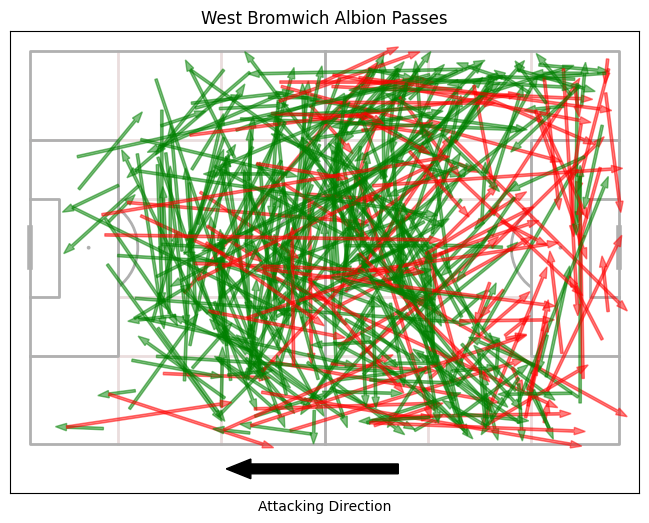

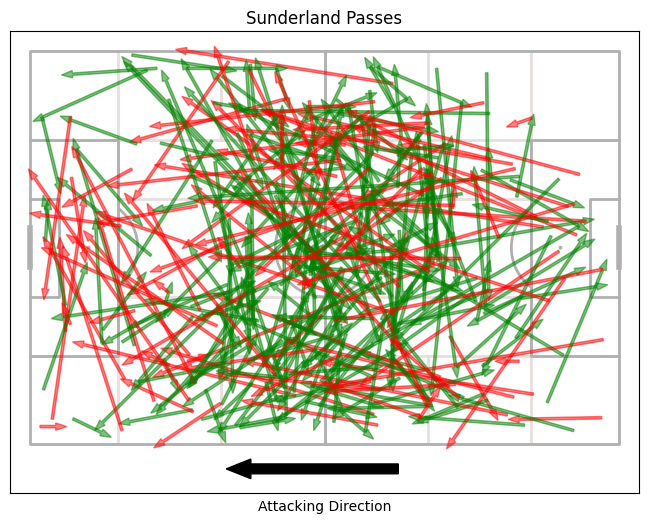

In [35]:
teams = [home_team,away_team]
for team in teams:
    pitch = Pitch(positional=True, axis=True,pad_bottom=10)
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)
    passes = ordered_events[(ordered_events["type"]=="Pass") & (ordered_events["team"] == team)]
    for i in range(len(passes)):
        row = passes.iloc[i]
        x, y = row["location"]
        x_end, y_end = row["end_loc"]
        result = row["outcome"]
        color = 'g' if result else 'r'
        plt.arrow(x, y, x_end-x, y_end-y, color=color, alpha=0.5, width=0.5, ls='-')
    plt.title(f"{team} Passes")
    plt.xlabel("Attacking Direction")
    # Add attacking direction arrows using ax instead of plt
    if team == "AFC Bournemouth":
        ax.arrow(45, 85, 30, 0, head_width=4, head_length=5, fc='black', ec='black', width=2)
    else:
        ax.arrow(75, 85, -30, 0, head_width=4, head_length=5, fc='black', ec='black', width=2)
    plt.show()

# Visualizing Possessions

In [36]:
ordered_events[ordered_events["possession"]==7][["type","pass_outcome","pass_type","duel_outcome","team","possession_team"]]

,type,pass_outcome,pass_type,duel_outcome,team,possession_team
2873,Clearance,NaN,NaN,NaN,West Bromwich Albion,Sunderland
2874,Clearance,NaN,NaN,NaN,West Bromwich Albion,Sunderland
45,Throw-in,NaN,Throw-in,NaN,Sunderland,Sunderland
1735,Carry,NaN,NaN,NaN,Sunderland,Sunderland
46,Pass,NaN,NaN,NaN,Sunderland,Sunderland
47,Pass,NaN,NaN,NaN,Sunderland,Sunderland
2942,Miscontrol,NaN,NaN,NaN,Sunderland,Sunderland
1736,Carry,NaN,NaN,NaN,Sunderland,Sunderland
2585,Ball Recovery,NaN,NaN,NaN,Sunderland,Sunderland
48,Pass,Pass Offside,NaN,NaN,Sunderland,Sunderland


In [13]:
def plot_possession(ordered_events,home_team,away_team,possession):
    away_team_df = ordered_events[ordered_events["team"] == away_team].copy()
    home_team_df = ordered_events[ordered_events["team"] == home_team].copy()

    # Function to flip coordinates
    def flip_coordinates(coords):
        if isinstance(coords, list):
            return [120 - coords[0], 80 - coords[1]]
        return coords

    # Flip all coordinate columns for away team
    coordinate_columns = ["location", "end_loc"]
    for column in coordinate_columns:
        away_team_df[column] = away_team_df[column].apply(flip_coordinates)

    # Combine home and away events
    ordered_events = pd.concat([home_team_df, away_team_df])

    possession_events = ordered_events[ordered_events["possession"] == possession]
    team = possession_events["possession_team"].unique()[0]
    
    # Create pitch visualization
    pitch = Pitch(positional=True, axis=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)
    
    # Sort events by timestamp and calculate width increment
    possession_events = possession_events.sort_values(by=["timestamp"], ascending=True)
    min_width = .5
    max_width = 5
    width_increment = (max_width - min_width) / len(possession_events)
    
    # Get first and last event locations
    first_event = possession_events.iloc[0]
    last_event = possession_events.iloc[-1]
    start_x, start_y = first_event["location"]
    end_x, end_y = last_event["location"]
    
    # Plot each event
    j=0
    for i, event in possession_events.iterrows():
        x, y = event["location"]
        event_team = event["team"]
        width = min_width + j * width_increment
        marker_size = 4 + j * 2

        if event["type"] in ["Goal Kick","Corner", "Free Kick", "Throw-in"] and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            color = 'k'
            linestyle = (0, (4, 4, 4, 4)) if event["type"] == "Throw-in" else '-'
            if event_team != team:
                color = 'gray'
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls=linestyle)
            
        elif event["type"] == "Pass" and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            color = 'g' if event["outcome"] else 'r'
            if event_team != team:
                color = 'gray'
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls='-')
            
        elif event["type"] == "Shot":
            plt.plot(x, y, 'y*', markersize=marker_size)
            
        elif event["type"] == "Ball Recovery":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}^', markersize=marker_size)
            
        elif event["type"] == "Carry" and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            plt.plot([x, end_x], [y, end_y], color='gray', alpha=0.5, linewidth=1+j, linestyle='--')
            
        elif event["type"] == "Duel":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'  # Opponent won duel = red
            else:
                color = 'r' if not event["outcome"] else 'g'  # Team won duel = green
            plt.plot(x, y, f'{color}o', markersize=marker_size)
            
        elif event["type"] == "Foul Committed":
            if event_team != team:
                color = 'g' if event["outcome"] else 'r'
            else:
                color = 'r' if event["outcome"] else 'g'
            plt.plot(x, y, f'{color}*', markersize=marker_size)
            
        elif event["type"] == "Clearance":
            plt.plot(x, y, 'm^', markersize=marker_size)

        elif event["type"] == "Interception":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}x', markersize=marker_size)
            
        elif event["type"] == "Dribble":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}D', markersize=marker_size)
            
        elif event["type"] == "Miscontrol":
            plt.plot(x, y, 'k+', markersize=marker_size)
            
        j+=width_increment
    
    # Add start and end text annotations
    offset = 5
    start_offset = offset if start_y > 40 else -offset
    end_offset = offset if end_y > 40 else -offset
    plt.annotate('START', xy=(start_x, start_y), xytext=(start_x+2, start_y+start_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    plt.annotate('END', xy=(end_x, end_y), xytext=(end_x+2, end_y+end_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    
    # Add title after annotations to ensure it's on top
    plt.title(f"{team} Possession {possession}", pad=35)  # Added padding to avoid overlap
            
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='g', marker='>', linestyle='-', label='Successful Pass', alpha=0.5),
        plt.Line2D([0], [0], color='r', marker='>', linestyle='-', label='Failed Pass', alpha=0.5),
        plt.Line2D([0], [0], color='gray', marker='>', linestyle='-', label='Opponent Pass', alpha=0.5),
        plt.Line2D([0], [0], color='k', linestyle=(0, (4, 4, 4, 4)), label='Throw-in', alpha=0.5),
        plt.Line2D([0], [0], color='k', marker='>', linestyle='-', label='Set Piece', alpha=0.5),
        plt.Line2D([0], [0], color='y', marker='*', linestyle='none', label='Shot', markersize=8),
        plt.Line2D([0], [0], color='gray', linestyle='--', label='Carry', alpha=0.5),
        plt.Line2D([0], [0], color='g', marker='^', linestyle='none', label='Successful Recovery', markersize=8),
        plt.Line2D([0], [0], color='r', marker='^', linestyle='none', label='Failed/Opponent Recovery', markersize=8),
        plt.Line2D([0], [0], color='g', marker='o', linestyle='none', label='Successful Duel', markersize=8),
        plt.Line2D([0], [0], color='r', marker='o', linestyle='none', label='Failed Duel', markersize=8),
        plt.Line2D([0], [0], color='g', marker='*', linestyle='none', label='Drawn Foul', markersize=8),
        plt.Line2D([0], [0], color='r', marker='*', linestyle='none', label='Committed Foul', markersize=8),
        plt.Line2D([0], [0], color='m', marker='^', linestyle='none', label='Clearance', markersize=8),
        plt.Line2D([0], [0], color='g', marker='x', linestyle='none', label='Interception', markersize=8),
        plt.Line2D([0], [0], color='g', marker='D', linestyle='none', label='Dribble', markersize=8),
        plt.Line2D([0], [0], color='k', marker='+', linestyle='none', label='Miscontrol', markersize=8),
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
# for possession in range(2,21):
#     plot_possession(possession)

In [38]:
#Possessions with shots
shots = ordered_events[ordered_events.type == "Shot"].sort_values(by=["possession"],ascending=[True])
# for possession in shots["possession"].unique():
#     plot_possession(possession)


# Adding the xG of a shot during possession to all events during possession

In [39]:
# Get all shots and their xG values
shots = ordered_events[ordered_events.type == "Shot"]
#Deduplicate by possession (e.g., keeping the first shot)
shots_dedup = shots.drop_duplicates(subset="possession")[["shot_statsbomb_xg", "possession"]] # first shot in possession
shots_max = shots.groupby("possession")[["shot_statsbomb_xg"]].max().reset_index() # max xG in possession
shots_sum = shots.groupby("possession")[["shot_statsbomb_xg"]].sum().reset_index() # sum xG in possession

# Get whether any shot in the possession was a goal
shots_goals = shots.groupby("possession")["outcome"].apply(lambda x: 1 if any(x == True) else 0).reset_index()
shots_goals = shots_goals.rename(columns={"outcome": "resulted_in_goal"})

# Merge both the max xG and goal outcome
ordered_events = ordered_events.merge(shots_max.rename(columns={"shot_statsbomb_xg": "max_xg_in_possession"}), 
                                    on="possession", how="left")
ordered_events = ordered_events.merge(shots_goals,
                                    on="possession", how="left")
ordered_events["resulted_in_goal"] = ordered_events["resulted_in_goal"].fillna(0)
ordered_events["max_xg_in_possession"] = ordered_events["resulted_in_goal"].fillna(0)



In [40]:
shots[['shot_outcome','outcome']]

,shot_outcome,outcome
3029,Off T,0.0
3030,Off T,0.0
3032,Off T,0.0
3033,Saved,0.0
3034,Blocked,0.0
3035,Blocked,0.0
3036,Goal,1.0
3037,Blocked,0.0
3038,Saved Off Target,0.0
3024,Blocked,0.0


# Creating DF for model

In [107]:
def preprocessing(events):
    ordered_events = events.sort_values(by=["period","timestamp"],ascending=[True,True])
    ordered_events = ordered_events[~ordered_events["location"].isna()]

    outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
    end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
    events = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Clearance": {},
        "Miscontrol": {},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
        "Foul Committed": {}
    }
    cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
    cols =sorted(cols)
    ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

    #make one outcome column
    def get_outcome(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1

        return np.nan

    ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
    ordered_events['outcome'].unique()


    #make one end_loc column
    def get_end_loc(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "end_loc" in event_dict:
            return row.get(event_dict["end_loc"], None)
        return np.nan

    ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

    #change type of event for special pass types
    special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
    ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]

    shots = ordered_events[ordered_events.type == "Shot"]
    # Find possessions that resulted in goals
    # Create a series of 1s for possessions that resulted in goals, 0s otherwise
    goals = pd.Series(1, index=shots[shots.shot_outcome == "Goal"]["possession"].unique())
    goals = pd.DataFrame({"possession": goals.index, "goal_in_possession": goals.values})

    # Merge goal information with events, filling non-goal possessions with 0
    ordered_events = ordered_events.merge(goals, on="possession", how="left")
    ordered_events["goal_in_possession"] = ordered_events["goal_in_possession"].fillna(0)

    potential_missing = ['pass_cross','pass_cut_back','pass_switch','pass_through_ball']
    for col in potential_missing:
        if col not in ordered_events.columns:
            ordered_events[col] = np.nan
    df = ordered_events[['possession',"type","outcome","location","end_loc",'pass_angle','pass_length','pass_cross','pass_cut_back','pass_switch','pass_through_ball','pass_height','goal_in_possession']]
    df = df[df["type"].isin(["Pass","Goal Kick","Corner","Free Kick","Throw-in"])]
    df['x1'] = df['location'].apply(lambda x: x[0])
    df['y1'] = df['location'].apply(lambda x: x[1])
    df['x2'] = df['end_loc'].apply(lambda x: x[0])
    df['y2'] = df['end_loc'].apply(lambda x: x[1])
    df = df.drop(['location', 'end_loc'], axis=1)

    # whether a pass was made from the center of the field i.e. not close to sideline
    df["start_distance_from_center"] = (df['y1']-40).abs()
    df['end_distance_from_center'] = (df['y2']-40).abs()

    #distance from goal on receiving end of pass
    df['end_distance_from_goal'] = ((120-df['x2']).pow(2) + (40-df['y2']).pow(2)).pow(0.5)
    # Calculate angle to goal from pass end point 
    df['end_angle_to_goal'] = np.arctan2(40-df['y2'], 120-df['x2'])

    df["pass_height"] = df["pass_height"].apply(lambda height: 2 if height == "High Pass" else 1 if height == "Low Pass" else 0)
    df["pass_cross"] = df["pass_cross"].fillna(0).astype(int)
    df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int) 
    df["pass_switch"] = df["pass_switch"].fillna(0).astype(int)
    df["pass_through_ball"] = df["pass_through_ball"].fillna(0).astype(int)
    # One-hot encode the type column
    type_dummies = pd.get_dummies(df['type'], prefix='pass').rename(columns=lambda x: x.replace(' ', '_').lower()).astype(int)
    df = pd.concat([df, type_dummies], axis=1)
    for i in range(1, 5):
            # Previous pass outcomes
            df[f'prev_pass{i}_outcome'] = df.groupby('possession')['outcome'].shift(i)

            # Previous pass angles
            df[f'prev_pass{i}_angle'] = df.groupby('possession')['pass_angle'].shift(i)
            
            # Previous pass lengths  
            df[f'prev_pass{i}_length'] = df.groupby('possession')['pass_length'].shift(i)

            # Previous pass types
            df[f'prev_pass{i}_cross'] = df.groupby('possession')['pass_cross'].shift(i)
            df[f'prev_pass{i}_cut_back'] = df.groupby('possession')['pass_cut_back'].shift(i)
            df[f'prev_pass{i}_switch'] = df.groupby('possession')['pass_switch'].shift(i)
            df[f'prev_pass{i}_through_ball'] = df.groupby('possession')['pass_through_ball'].shift(i)
            df[f'prev_pass{i}_height'] = df.groupby('possession')['pass_height'].shift(i)

            
            # Previous pass start coordinates
            df[f'prev_pass{i}_x1'] = df.groupby('possession')['x1'].shift(i)
            df[f'prev_pass{i}_y1'] = df.groupby('possession')['y1'].shift(i)
            
            # Previous pass end coordinates
            df[f'prev_pass{i}_x2'] = df.groupby('possession')['x2'].shift(i)
            df[f'prev_pass{i}_y2'] = df.groupby('possession')['y2'].shift(i)

            df[f'prev_pass{i}_start_distance_from_center'] = df.groupby('possession')['start_distance_from_center'].shift(i)
            df[f'prev_pass{i}_end_distance_from_center'] = df.groupby('possession')['end_distance_from_center'].shift(i)

            df[f'prev_pass{i}_end_distance_from_goal'] = df.groupby('possession')['end_distance_from_goal'].shift(i)
            df[f'prev_pass{i}_end_angle_to_goal'] = df.groupby('possession')['end_angle_to_goal'].shift(i)
            
            # Previous pass type dummies
            for col in type_dummies.columns:
                df[f'prev_pass{i}_{col}'] = df.groupby('possession')[col].shift(i)
    cols_to_drop = [col for col in df.columns if 'pass_pass' in col] + ['type','possession']
    df = df.drop(cols_to_drop,axis=1)
    return df

dfs = []
for match_id in matches.match_id:
    dfs.append(preprocessing(sb.events(match_id=match_id)))
model_df = pd.concat(dfs)
model_df

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\s

,outcome,pass_angle,pass_length,pass_cross,pass_cut_back,pass_switch,pass_through_ball,pass_height,goal_in_possession,x1,...,prev_pass4_x2,prev_pass4_y2,prev_pass4_start_distance_from_center,prev_pass4_end_distance_from_center,prev_pass4_end_distance_from_goal,prev_pass4_end_angle_to_goal,prev_pass4_pass_corner,prev_pass4_pass_free_kick,prev_pass4_pass_goal_kick,prev_pass4_pass_throw-in
0,1.0,1.740575,3.551056,0,0,0,0,0,0.0,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,-2.989549,12.544720,0,0,0,0,0,0.0,60.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.867047,35.966790,0,0,0,0,0,0.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,-2.120081,19.345800,0,0,0,0,0,0.0,37.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,1.064920,15.890248,0,0,0,0,0,0.0,27.4,...,60.4,43.6,0.1,3.6,59.708626,-0.060329,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,0.0,-0.044089,6.806614,0,0,0,0,0,0.0,65.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025,1.0,1.518895,7.710382,0,0,0,0,0,0.0,53.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2027,0.0,-1.815775,3.298485,0,0,0,0,1,0.0,54.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030,1.0,-0.349607,10.218122,0,0,0,0,1,0.0,63.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
model_df.to_parquet('model_dataframeV3.parquet',index=False,engine='pyarrow')

In [118]:
model_df.columns.tolist()

['outcome',
 'pass_angle',
 'pass_length',
 'pass_cross',
 'pass_cut_back',
 'pass_switch',
 'pass_through_ball',
 'pass_height',
 'goal_in_possession',
 'x1',
 'y1',
 'x2',
 'y2',
 'start_distance_from_center',
 'end_distance_from_center',
 'end_distance_from_goal',
 'end_angle_to_goal',
 'pass_corner',
 'pass_free_kick',
 'pass_goal_kick',
 'pass_throw-in',
 'prev_pass1_angle',
 'prev_pass1_length',
 'prev_pass1_x1',
 'prev_pass1_y1',
 'prev_pass1_x2',
 'prev_pass1_y2',
 'prev_pass1_start_distance_from_center',
 'prev_pass1_end_distance_from_center',
 'prev_pass1_end_distance_from_goal',
 'prev_pass1_end_angle_to_goal',
 'prev_pass1_outcome',
 'prev_pass1_cross',
 'prev_pass1_cut_back',
 'prev_pass1_switch',
 'prev_pass1_through_ball',
 'prev_pass1_height',
 'prev_pass1_pass_corner',
 'prev_pass1_pass_free_kick',
 'prev_pass1_pass_goal_kick',
 'prev_pass1_pass_throw-in',
 'prev_pass2_angle',
 'prev_pass2_length',
 'prev_pass2_x1',
 'prev_pass2_y1',
 'prev_pass2_x2',
 'prev_pass2_y2',

# Training XGBoost Model to predict xG given passing sequence

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

In [44]:
model_df = pd.read_parquet('model_dataframe.parquet')

X = model_df.drop("max_xg_in_possession",axis=1)
y = model_df["max_xg_in_possession"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Trying simple regression XGBoost model

In [45]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.7f}")

RMSE: 0.0033421


In [47]:
y_pred.max()

0.54962593

## Trying to tune hyper parameters for XGBoost Regression

In [48]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # RMSE (negated, because higher = better)
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

# Evaluate on validation set
y_pred = grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("Validation RMSE:", rmse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV RMSE: 0.05797113418665349
Validation RMSE: 0.0032704448519354184


In [49]:
model = grid_search.best_estimator_

In [50]:
model.save_model("xgboost_model_r_xg.json")

## Looking at using XGBoost Classification Instead

In [109]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
model_df = pd.read_parquet('model_dataframeV3.parquet')

X = model_df.drop("goal_in_possession",axis=1)
y = model_df["goal_in_possession"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [110]:
from sklearn.metrics import confusion_matrix, classification_report
scale_pos_weight = np.sqrt(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='aucpr',objective='binary:logistic',scale_pos_weight=scale_pos_weight,learning_rate= 0.05,max_depth= 3, n_estimators= 50)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Max predicted probability of goal being scored: ", model.predict_proba(X_test)[:,1].max())

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Metrics
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

print("Confusion Matrix:\n", cm)
print(f"False Positive Rate: {false_positive_rate:.2f}")
print(f"False Negative Rate: {false_negative_rate:.2f}")
print("yikes")

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:52:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.98
Max predicted probability of goal being scored:  0.7617181
Confusion Matrix:
 [[72403   181]
 [ 1092    48]]
False Positive Rate: 0.00
False Negative Rate: 0.96
yikes


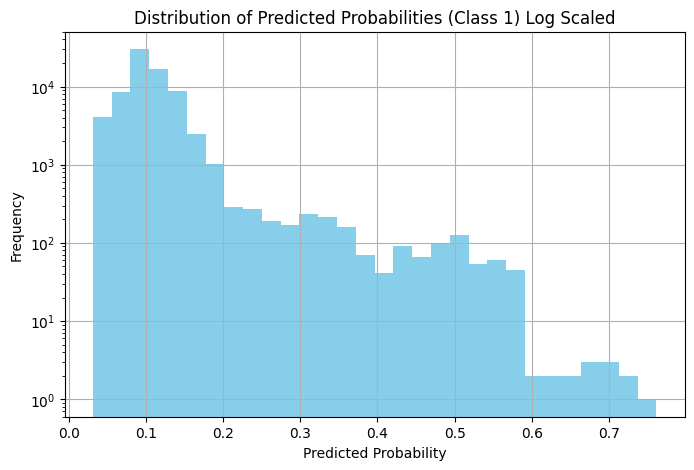

0.7617181 0.10892544


In [111]:
y_probs = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 5))
plt.hist(y_probs, bins=30, color='skyblue')
plt.title("Distribution of Predicted Probabilities (Class 1) Log Scaled")
plt.xlabel("Predicted Probability") 
plt.ylabel("Frequency")
plt.yscale('log')  # Set y-axis to log scale
plt.grid(True)
plt.show()
print(y_probs.max(),y_probs.mean())

In [103]:
# 2. Define model
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = xgb.XGBClassifier(use_label_encoder=False)

# 3. Define parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],          # Number of trees
    "max_depth": [3, 5, 7],                   # Maximum tree depth
    "learning_rate": [0.01, 0.05, 0.1, 0.2], 
    "scale_pos_weight":[scale_pos_weight,np.sqrt(scale_pos_weight)],
    "objective": ["binary:logistic"],               # Binary classification
    "eval_metric": ["logloss", "aucpr"]               # Evaluation metrics
}

# 4. Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='balanced_accuracy',  # Change to 'roc_auc' for AUC
    verbose=1,
    n_jobs=-1  # Use all processors
)

# 5. Fit
grid_search.fit(X_train, y_train)

# 6. Best model and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# 7. Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'eval_metric': 'logloss', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'objective': 'binary:logistic', 'scale_pos_weight': 65.2685393258427}
Best CV Score: 0.6076574071441323
Test Accuracy: 0.7021729694536379


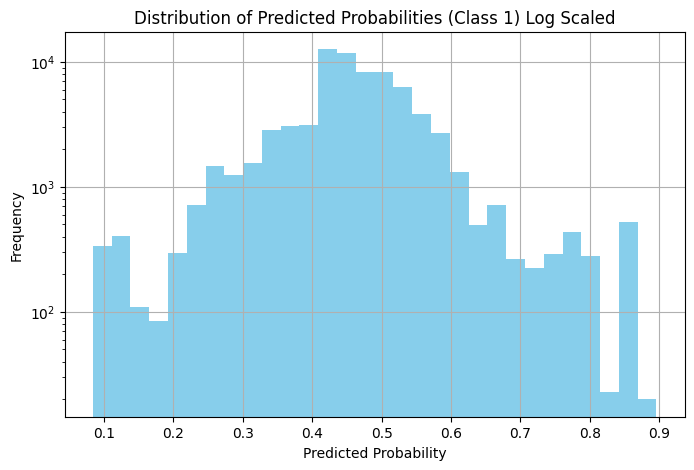

In [105]:
y_probs = best_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 5))
plt.hist(y_probs, bins=30, color='skyblue')
plt.title("Distribution of Predicted Probabilities (Class 1) Log Scaled")
plt.xlabel("Predicted Probability") 
plt.ylabel("Frequency")
plt.yscale('log')  # Set y-axis to log scale
plt.grid(True)
plt.show()

# Making the final model (XGBoost Classifier)

In [115]:
scale_pos_weight = np.sqrt(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
final_xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='aucpr',objective='binary:logistic',scale_pos_weight=scale_pos_weight,learning_rate= 0.05,max_depth= 3, n_estimators= 50)
final_xgb_model.fit(X,y)
print(final_xgb_model.predict_proba(X)[:,1].max(),final_xgb_model.predict_proba(X)[:,1].mean())
final_xgb_model.save_model('final_xgb_modelV2.json')




0.7486043 0.10916445


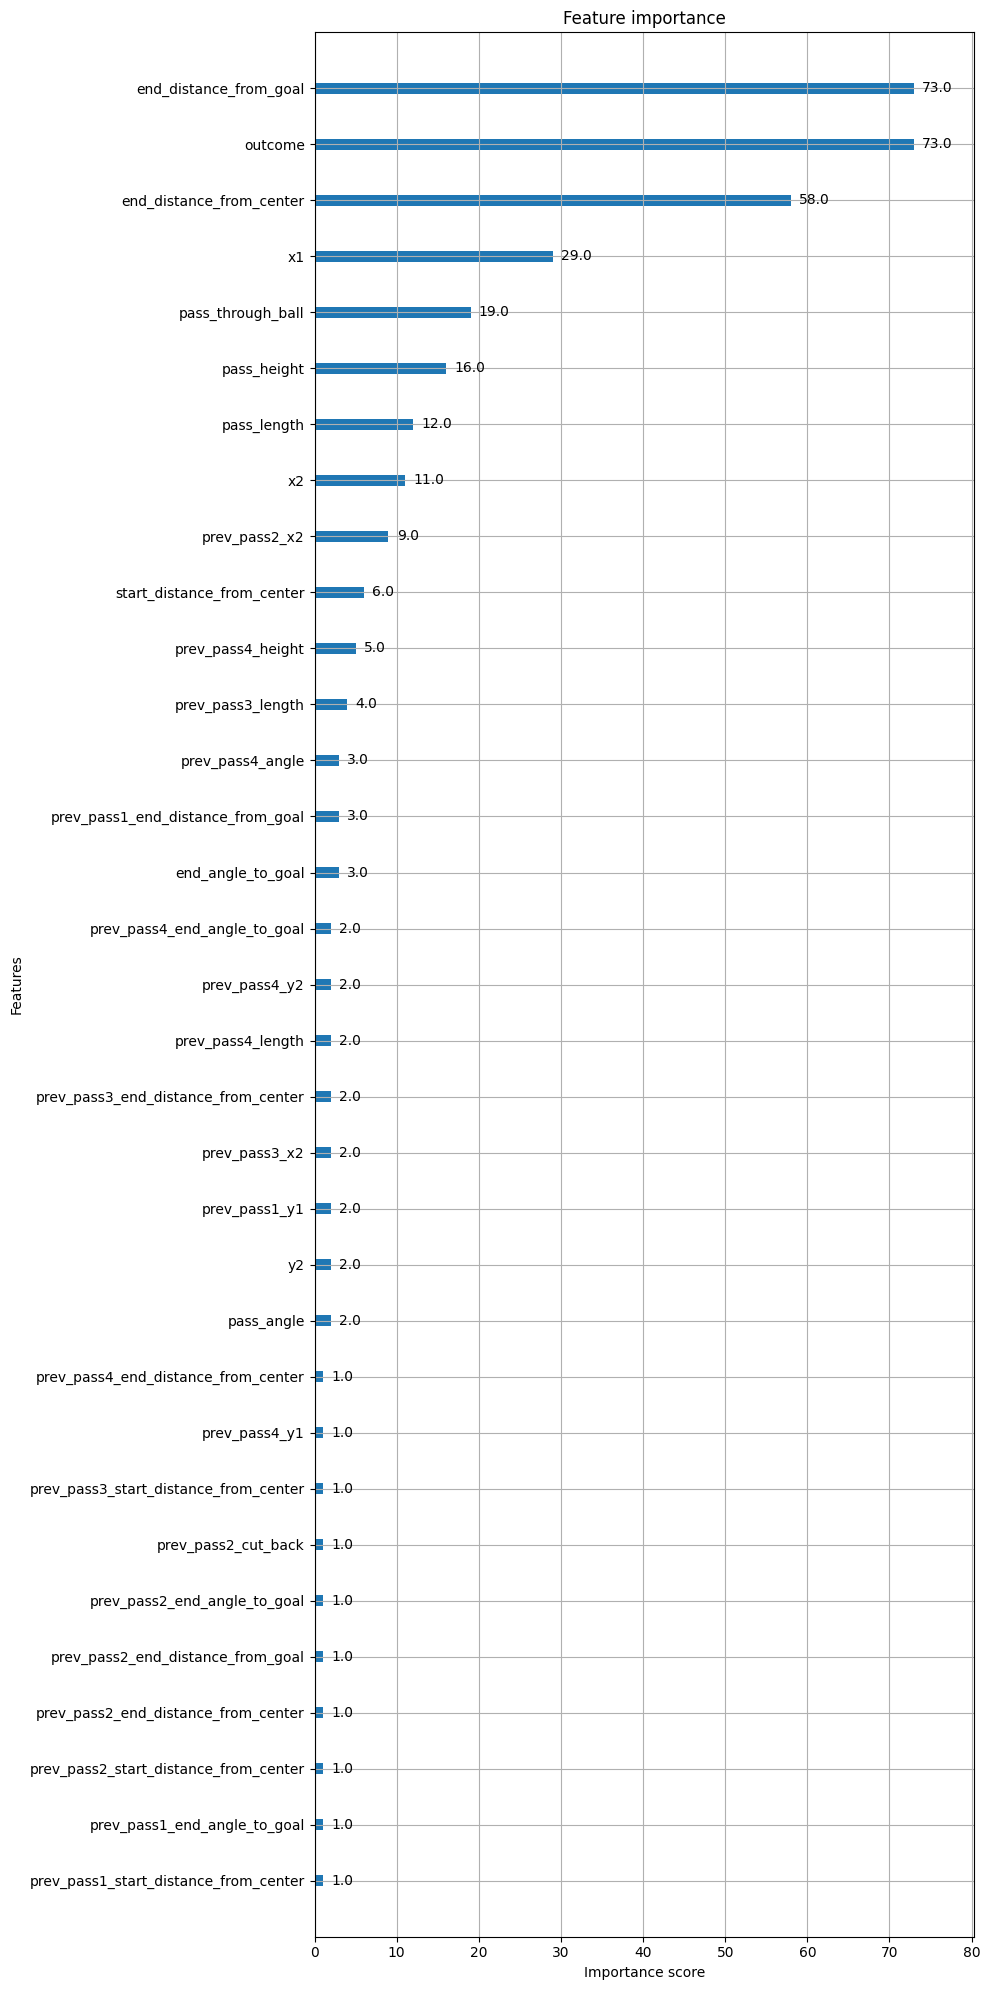

In [116]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(final_xgb_model,ax=ax)
plt.tight_layout()
plt.show()

# Testing Preprocessing classes

In [14]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

class PassPreprocessor:
    def __init__(self):
        self.events = {
            "Pass": {
                "outcome": {
                    'col': 'pass_outcome',
                    False: {'Out', 'Incomplete', 'Unknown', 'Injury Clearance', 'Pass Offside'}
                },
                'end_loc': 'pass_end_location'
            },
            "Carry": {'end_loc': 'carry_end_location'},
            "Ball Recovery": {
                "outcome": {'col': 'ball_recovery_recovery_failure', False: {True}}
            },
            "Duel": {
                "outcome": {'col': 'duel_outcome', False: {'Lost', 'Lost In Play', 'Lost Out', np.nan}}
            },
            "Clearance": {},
            "Miscontrol": {},
            "Dribble": {
                "outcome": {'col': 'dribble_outcome', False: {'Incomplete'}}
            },
            "Shot": {
                "outcome": {
                    'col': 'shot_outcome',
                    False: {'Off T', 'Post', 'Saved', 'Wayward', 'Blocked', 'Saved Off T',
                           'Saved To Post', 'Saved Off Target', 'Off Target'}
                }
            },
            "Interception": {
                "outcome": {'col': 'interception_outcome', False: {'Lost', 'Lost In Play', 'Lost Out'}}
            },
            "Foul Committed": {}
        }
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, events):
        # Sort events chronologically
        ordered_events = events.sort_values(by=["period", "timestamp"])
        ordered_events = ordered_events[~ordered_events["location"].isna()]

        # Select relevant columns
        event_related_cols = [col for col in ordered_events.columns 
                             if any([event.lower().replace(" ","_") in col.lower() 
                                   for event in self.events.keys()])]
        base_cols = ["type", "possession", "possession_team", "team", 'team_id', "location",
                    "timestamp", "period", "duration", "id", "match_id", "minute", "second",
                    'player', 'player_id', 'under_pressure', 'period', 'position']
        cols = sorted(event_related_cols + base_cols)
        
        ordered_events = ordered_events[ordered_events["type"].isin(self.events.keys())][cols]

        # Create unified outcome column
        ordered_events["outcome"] = ordered_events.apply(self._get_outcome, axis=1)

        # Create unified end location column
        ordered_events["end_loc"] = ordered_events.apply(self._get_end_loc, axis=1)

        # Handle special pass types
        special_pass_types = ['Corner', 'Free Kick', 'Throw-in', "Goal Kick"]
        ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]

        # Get max xG per possession
        shots_max = ordered_events[ordered_events.type == "Shot"].groupby("possession")[["shot_statsbomb_xg"]].max()
        # ordered_events = ordered_events.merge(
        #     shots_max.rename(columns={"shot_statsbomb_xg": "max_xg_in_possession"}),
        #     on="possession",
        #     how="left"
        # )
        #ordered_events["max_xg_in_possession"] = ordered_events["max_xg_in_possession"].fillna(0)

        # Filter for passes and extract coordinates
        df = ordered_events[ordered_events.type == "Pass"]
        df = df[['possession', "type", "outcome", "location", "end_loc", 
                 'pass_angle', 'pass_length']]
        
        for point, coords in [('1', 'location'), ('2', 'end_loc')]:
            df[f'x{point}'] = df[coords].apply(lambda x: x[0])
            df[f'y{point}'] = df[coords].apply(lambda x: x[1])
        df = df.drop(['location', 'end_loc'], axis=1)

        # Calculate distances and angles
        df["start_distance_from_center"] = (df['y1'] - 40).abs()
        df['end_distance_from_center'] = (df['y2'] - 40).abs()
        df['end_distance_from_goal'] = ((120 - df['x2']).pow(2) + (40 - df['y2']).pow(2)).pow(0.5)
        df['end_angle_to_goal'] = np.arctan2(40 - df['y2'], 120 - df['x2'])

        # Create features from previous 5 passes
        features = {
            'angle': 'pass_angle',
            'length': 'pass_length',
            'x1': 'x1',
            'y1': 'y1', 
            'x2': 'x2',
            'y2': 'y2',
            'start_distance_from_center': 'start_distance_from_center',
            'end_distance_from_center': 'end_distance_from_center',
            'end_distance_from_goal': 'end_distance_from_goal',
            'end_angle_to_goal': 'end_angle_to_goal',
            'outcome': 'outcome'
        }

        for i in range(1, 5):
            for feature, col in features.items():
                df[f'prev_pass{i}_{feature}'] = df.groupby('possession')[col].shift(i)

        return df.drop(['possession', 'type'], axis=1)
        
    def _get_outcome(self, row):
        event_dict = self.events.get(row["type"], {})
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            return 0 if row.get(outcome_col) in event_dict["outcome"][False] else 1
        return np.nan
        
    def _get_end_loc(self, row):
        event_dict = self.events.get(row["type"], {})
        return row.get(event_dict.get("end_loc")) if "end_loc" in event_dict else np.nan

game = sb.events(match_id=match_id)


# Create pipeline 
pipeline = Pipeline([
    ('game_processor', PassPreprocessor())
])

# Process the game data through the pipeline
processed_game = pipeline.transform(game)

processed_game

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,outcome,pass_angle,pass_length,x1,y1,x2,y2,start_distance_from_center,end_distance_from_center,end_distance_from_goal,...,prev_pass4_length,prev_pass4_x1,prev_pass4_y1,prev_pass4_x2,prev_pass4_y2,prev_pass4_start_distance_from_center,prev_pass4_end_distance_from_center,prev_pass4_end_distance_from_goal,prev_pass4_end_angle_to_goal,prev_pass4_outcome
6,1.0,-2.982596,34.738163,60.0,40.0,25.7,34.5,0.0,5.5,94.460256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,0.462286,65.695740,30.4,24.1,89.2,53.4,15.9,13.4,33.588689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.340577,30.236732,30.9,26.7,59.4,36.8,13.3,3.2,60.684430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.316825,25.678005,60.7,43.3,85.1,51.3,3.3,11.3,36.683784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1.0,-1.089909,12.971122,35.0,36.5,41.0,25.0,3.5,15.0,80.411442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,1.0,0.577192,15.393830,64.6,39.4,77.5,47.8,0.6,7.8,43.209837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1066,1.0,-1.147127,22.378561,76.7,41.4,85.9,21.0,1.4,19.0,39.036009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1067,1.0,-0.907241,20.944212,89.0,20.8,101.9,4.3,19.2,35.7,40.026241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1068,1.0,1.387757,50.544340,101.9,4.3,111.1,54.0,35.7,14.0,16.589454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Testing possible inputs from html for pipeline to process and then predict

In [2]:
pass1startloc = [40, 20]
pass1endloc = [30, 60]
pass1outcome = 1  # Successful pass moving up field
pass1type = "Throw-in"
pass1height = "Ground"

pass2startloc = [85, 45] 
pass2endloc = [95, 30]
pass2outcome = 0  # Failed pass - too close to goal line
pass2type = "Pass"
pass2height = "Ground"

pass3startloc = [15, 70]
pass3endloc = [25, 75]
pass3outcome = 1  # Successful short pass forward
pass3type = "Pass"
pass3height = "Ground"

pass4startloc = [60, 10]
pass4endloc = [75, 25]
pass4outcome = 1  # Successful diagonal pass upfield
pass4type = "Pass"
pass4height = "Ground"

pass5startloc = [110, 65]
pass5endloc = [100, 50]
pass5outcome = 0
pass5type = "Cross"
pass5height = "High"

inputs = [
    pass1startloc, pass1endloc, pass1outcome, pass1type, pass1height,
    pass2startloc, pass2endloc, pass2outcome, pass2type, pass2height,
    pass3startloc, pass3endloc, pass3outcome, pass3type, pass3height,
    pass4startloc, pass4endloc, pass4outcome, pass4type, pass4height,
    #pass5startloc, pass5endloc, pass5outcome, pass5type, pass5height,
]
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class websiteInputPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # Initialize array to store features
        features = []
        
        # Process each pass (every 5 elements in input list)
        for i in range(0, len(X), 5):
            idx = i // 5  # Get pass number (0-4)
            start_loc = X[i]
            end_loc = X[i+1]
            outcome = X[i+2]
            
            # Calculate pass features
            pass_angle = np.arctan2(end_loc[1] - start_loc[1], end_loc[0] - start_loc[0])
            pass_length = np.sqrt((end_loc[0] - start_loc[0])**2 + (end_loc[1] - start_loc[1])**2)
            
            # Calculate distances and angles
            start_dist_center = np.abs(start_loc[0] - 40)
            end_dist_center = np.abs(end_loc[0] - 40)
            end_dist_goal = np.sqrt((end_loc[0] - 120)**2 + (end_loc[1] - 40)**2)
            end_angle_goal = np.arctan2(end_loc[1] - 40, end_loc[0] - 120)
            pass_type = X[i+3]
            pass_height = 0 if X[i+4] == "Ground" else 1 if X[i+4] == "Low" else 2
            cross = 1 if pass_type == "Cross" else 0
            throw_in = 1 if pass_type == "Throw-in" else 0
            corner = 1 if pass_type == "Corner" else 0
            free_kick = 1 if pass_type == "Free Kick" else 0
            goal_kick = 1 if pass_type == "Goal Kick" else 0
            cut_back = 1 if pass_type == "Cut-back" else 0
            switch = 1 if pass_type == "Switch" else 0
            through_ball = 1 if pass_type == "Through Ball" else 0

            # Add features in order
            features.extend([
                outcome,
                pass_angle,
                pass_length,
                cross,
                cut_back,
                switch,
                through_ball,
                pass_height,
                start_loc[0],
                start_loc[1],
                end_loc[0],
                end_loc[1],
                start_dist_center,
                end_dist_center,
                end_dist_goal,
                end_angle_goal,
                throw_in,
                corner,
                free_kick,
                goal_kick
            ])
        expected_length = 100  # 5 passes * 20 features per pass
        if len(features) < expected_length:
            features.extend([np.nan] * (expected_length - len(features)))
        return np.array(features).reshape(1, -1)

import xgboost as xgb

model = xgb.XGBClassifier() 
model.load_model("final_xgb_modelV2.json")  

from sklearn.pipeline import make_pipeline

websitePipeline = make_pipeline(
    websiteInputPreprocessor(),
    model
)
prediction = websitePipeline.predict_proba(inputs)[0,1]
print(prediction)

0.09478395


# Looking at now specific moments in EUFA Euros

In [21]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt
matches = sb.matches(55, 282)
matches.head()

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3942819,2024-07-10,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,England,1,2,available,...,2024-07-15T07:57:36.684453,6,Semi-finals,Signal-Iduna-Park,Felix Zwayer,Ronald Koeman,Gareth Southgate,1.1.0,2,2
1,3943043,2024-07-14,22:00:00.000,Europe - UEFA Euro,2024,Spain,England,2,1,available,...,2024-07-15T15:52:24.778809,7,Final,Olympiastadion Berlin,François Letexier,Luis de la Fuente Castillo,Gareth Southgate,1.1.0,2,2
2,3942752,2024-07-09,22:00:00.000,Europe - UEFA Euro,2024,Spain,France,2,1,available,...,2024-07-10T13:01:26.597509,6,Semi-finals,Allianz Arena,Slavko Vinčić,Luis de la Fuente Castillo,Didier Deschamps,1.1.0,2,2
3,3942382,2024-07-06,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,Turkey,2,1,available,...,2024-07-10T06:56:35.146850,5,Quarter-finals,Olympiastadion Berlin,Clément Turpin,Ronald Koeman,Vincenzo Montella,1.1.0,2,2
4,3942349,2024-07-05,22:00:00.000,Europe - UEFA Euro,2024,Portugal,France,0,0,available,...,2024-07-12T02:00:16.871522,5,Quarter-finals,Volksparkstadion,Michael Oliver,Roberto Martínez Montoliú,Didier Deschamps,1.1.0,2,2


# Finding the goal of the tournament (Lamine Yamal Quarterfinal)

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


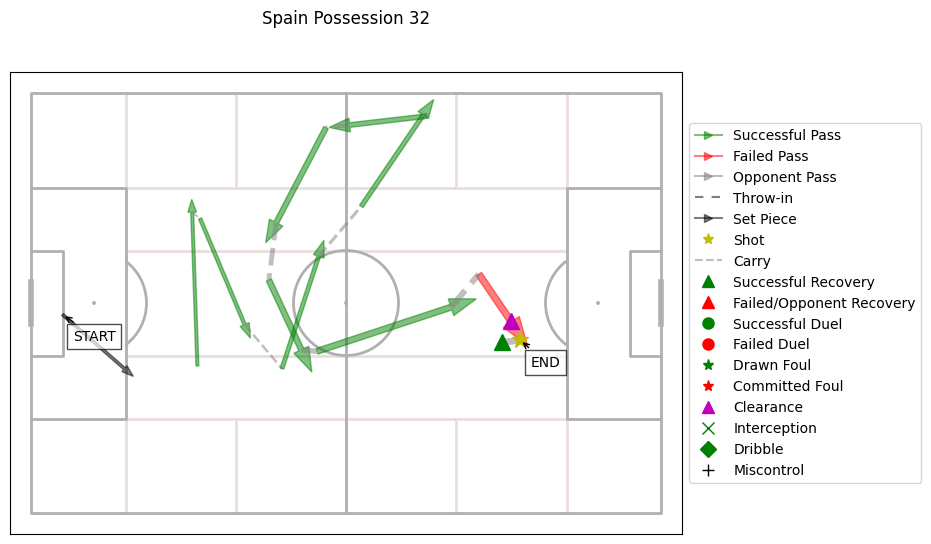

In [51]:
match = matches[(matches.competition_stage=="Semi-finals")&(matches.home_team == "Spain")]
home_team =match.home_team.iloc[0]
away_team = match.away_team.iloc[0]
match_id = matches[(matches.competition_stage=="Semi-finals")&(matches.home_team == "Spain")].match_id.iloc[0]
events = sb.events(match_id)
processed_events = preprocessing(events)
possesion_num = processed_events[(processed_events.type=="Shot") & (processed_events.outcome==True)&(processed_events.player.str.contains("Lamine Yamal"))].possession.iloc[0]
plot_possession(processed_events,home_team,away_team,possesion_num)


In [62]:
processed_events['type'].unique()

array(['Pass', 'Carry', 'Dribble', 'Ball Recovery', 'Duel', 'Throw-in',
       'Miscontrol', 'Goal Kick', 'Foul Committed', 'Free Kick',
       'Clearance', 'Shot', 'Interception', 'Corner'], dtype=object)

In [130]:
possession_events = processed_events[processed_events.possession==possesion_num]

# Filter for passes and get the last 5 before the shot
five_passes_before_shot = possession_events[
    (possession_events.index < possession_events[possession_events.type=="Shot"].index[0])
].head(5)
five_passes_before_shot
# passes_before_shot = five_passes_before_shot.reset_index().sort_values("index",ascending=False)
# input =processed_to_model(passes_before_shot)
# input
#print("Probability of scoring given the 5 passes before: ",model.predict_proba([input])[0,1])

,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_other,clearance_right_foot,dribble_nutmeg,dribble_outcome,...,shot_statsbomb_xg,shot_technique,shot_type,team,team_id,timestamp,type,under_pressure,outcome,end_loc
219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Spain,772,00:19:40.732,Goal Kick,NaN,1.0,"[17.8, 52.5]"
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Spain,772,00:19:46.050,Pass,NaN,1.0,"[30.7, 22.7]"
2016,NaN,"[32.2, 23.9]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Spain,772,00:19:47.681,Carry,NaN,NaN,"[32.2, 23.9]"
221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Spain,772,00:19:49.173,Pass,NaN,1.0,"[40.7, 44.1]"
2017,NaN,"[47.8, 52.5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Spain,772,00:19:50.537,Carry,NaN,NaN,"[47.8, 52.5]"


In [128]:
# Get all events in the possession
possession_events = processed_events[processed_events.possession==possesion_num]

# Filter for passes and get the last 5 before the shot
passes_before_shot = possession_events[
    (possession_events.type=="Pass") & 
    (possession_events.index < possession_events[possession_events.type=="Shot"].index[0])
].tail(5)

passes_before_shot = passes_before_shot.reset_index().sort_values("index",ascending=False)
input =processed_to_model(passes_before_shot).iloc[-1]
print("Probability of scoring given the 5 passes before: ",model.predict_proba([input])[0,1])

Probability of scoring given the 5 passes before:  0.10510004


C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\532672612.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pass_cross"] = df["pass_cross"].fillna(0).astype(int)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\532672612.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\532672612.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_ob

In [127]:
def create_array_from_input(input):
    input = input.to_numpy()
    passes = []
    for i in range(0,len(input),20):
        pass_idx = i//20
        passoutcome = input[0+i]
        passStart = input[i+8:i+10].tolist()
        passEnd = input[i+10:i+12].tolist()
        passCross = input[i+3]
        passCutBack = input[i+4]
        passSwitch = input[i+5]
        passThrough = input[i+6]
        passHeight = input[i+7]

        passCorner = input[i+16]
        passFreeKick = input[i+17]
        passGoalKick = input[i+18]
        passThrowIn = input[i+19]
        if passCorner:
            passType = "Corner"
        elif passFreeKick:
            passType = "Free Kick"
        elif passGoalKick:
            passType = "Goal Kick"
        elif passThrowIn:
            passType = "Throw-in"
        elif passCross:
            passType = "Cross"
        elif passCutBack:
            passType = "Cut-back"
        elif passSwitch:
            passType = "Switch"
        elif passThrough:
            passType = "Through Ball"
        else:
            passType = "Pass"
        passes.append({
            "outcome": passoutcome,
            "start": passStart,
            "end": passEnd,
            "type": passType,
            "height": passHeight
        })
    return passes
result = create_array_from_input(input)
with open("lamine_chance_last_5.json", "w") as f:
    json.dump(result, f, indent=2)





# Looking at all pass sequences in all euro games

In [78]:
import pandas as pd
dfs = []
for match_id in matches.match_id:
    df = sb.events(match_id=match_id)
    df = preprocessing_for_model_input(df)
    preds = model.predict_proba(df)[:,1]
    df["sequence_pred"] = preds
    dfs.append(df)
all_sequences = pd.concat(dfs)







c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\s

In [79]:
all_sequences.head()

,outcome,pass_angle,pass_length,pass_cross,pass_cut_back,pass_switch,pass_through_ball,pass_height,x1,y1,...,prev_pass4_cross,prev_pass4_cut_back,prev_pass4_switch,prev_pass4_through_ball,prev_pass4_height,prev_pass4_pass_corner,prev_pass4_pass_free_kick,prev_pass4_pass_goal_kick,prev_pass4_pass_throw-in,sequence_pred
6,1.0,1.740575,3.551056,0,0,0,0,0,61.0,40.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101609
7,1.0,-2.989549,12.544720,0,0,0,0,0,60.4,43.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101687
8,1.0,1.867047,35.966790,0,0,0,0,0,48.0,41.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093315
9,1.0,-2.120081,19.345800,0,0,0,0,0,37.5,74.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090025
10,1.0,1.064920,15.890248,0,0,0,0,0,27.4,63.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093110


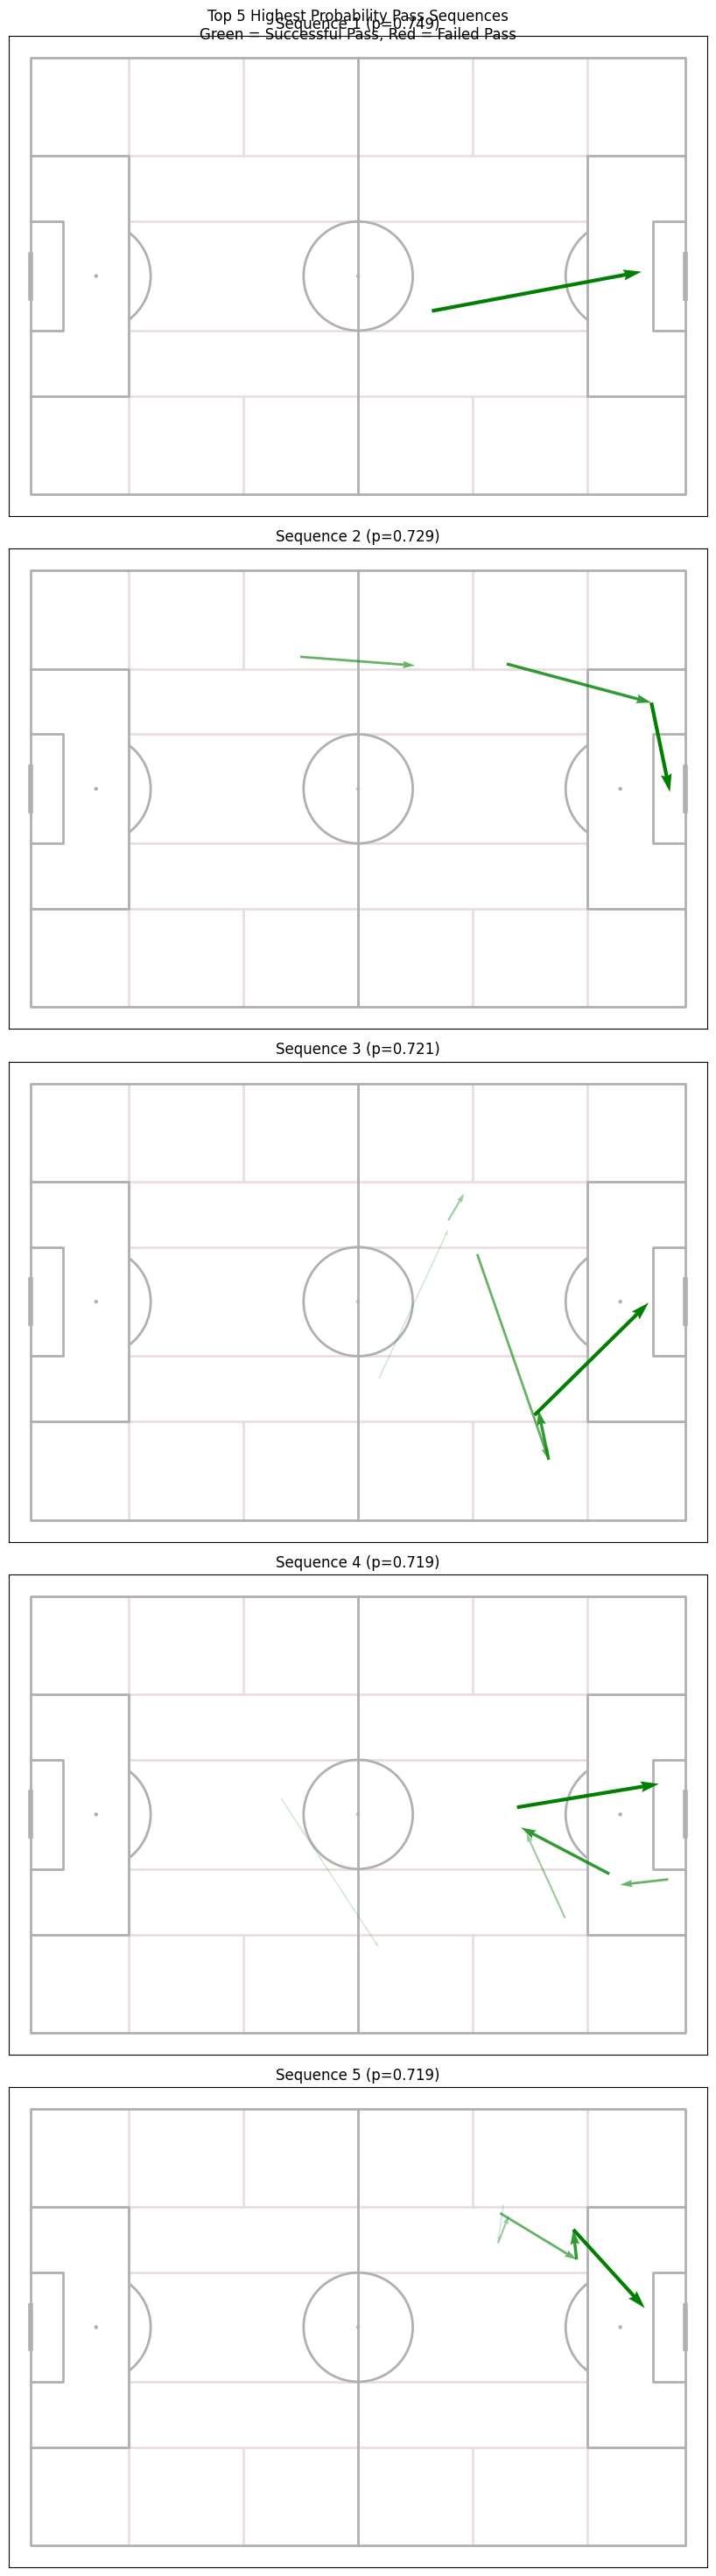

In [90]:
# Get coordinates of top 5 highest probability sequences
top_5_coords = all_sequences.sort_values("sequence_pred", ascending=False).head(5)

# Create pitch visualization
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Define colors based on pass outcome
success_color = 'green'
fail_color = 'red'

# Create subplots for each sequence
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
fig.suptitle('Top 5 Highest Probability Pass Sequences\nGreen = Successful Pass, Red = Failed Pass')

for idx, (_, coords) in enumerate(top_5_coords.iterrows()):
    pitch = Pitch(positional=True, axis=True)
    ax=axes[idx]
    pitch.draw(ax=ax)
    
    # Plot each pass in sequence with different alphas and line thicknesses
    alphas = [1.0, 0.8, 0.6, 0.4, 0.2]
    linewidths = [3, 2.5, 2, 1.5, 1]

    # Plot pass 4 (earliest)
    if not pd.isna(coords.prev_pass4_x1):
        color = success_color if coords.prev_pass4_outcome == 1.0 else fail_color
        pitch.arrows(coords.prev_pass4_x1, coords.prev_pass4_y1, 
                    coords.prev_pass4_x2, coords.prev_pass4_y2,
                    ax=ax, color=color, alpha=alphas[4], width=linewidths[4])

    # Plot pass 3
    if not pd.isna(coords.prev_pass3_x1):
        color = success_color if coords.prev_pass3_outcome == 1.0 else fail_color
        pitch.arrows(coords.prev_pass3_x1, coords.prev_pass3_y1,
                    coords.prev_pass3_x2, coords.prev_pass3_y2, 
                    ax=ax, color=color, alpha=alphas[3], width=linewidths[3])

    # Plot pass 2  
    if not pd.isna(coords.prev_pass2_x1):
        color = success_color if coords.prev_pass2_outcome == 1.0 else fail_color
        pitch.arrows(coords.prev_pass2_x1, coords.prev_pass2_y1,
                    coords.prev_pass2_x2, coords.prev_pass2_y2,
                    ax=ax, color=color, alpha=alphas[2], width=linewidths[2])

    # Plot pass 1
    if not pd.isna(coords.prev_pass1_x1):
        color = success_color if coords.prev_pass1_outcome == 1.0 else fail_color
        pitch.arrows(coords.prev_pass1_x1, coords.prev_pass1_y1,
                    coords.prev_pass1_x2, coords.prev_pass1_y2,
                    ax=ax, color=color, alpha=alphas[1], width=linewidths[1])

    # Plot final pass
    color = success_color if coords.outcome == 1.0 else fail_color
    pitch.arrows(coords.x1, coords.y1, coords.x2, coords.y2,
                ax=ax, color=color, alpha=alphas[0], width=linewidths[0])
    
    ax.set_title(f'Sequence {idx+1} (p={round(coords.sequence_pred,3)})')

plt.tight_layout()
plt.show()


In [86]:
coords.head(20)

outcome                         1.000000
pass_angle                     -0.185348
pass_length                    39.069168
pass_cross                      0.000000
pass_cut_back                   0.000000
pass_switch                     0.000000
pass_through_ball               1.000000
pass_height                     2.000000
x1                             73.500000
y1                             46.400000
x2                            111.900000
y2                             39.200000
start_distance_from_center      6.400000
end_distance_from_center        0.800000
end_distance_from_goal          8.139410
end_angle_to_goal               0.098446
pass_corner                     0.000000
pass_free_kick                  1.000000
pass_goal_kick                  0.000000
pass_throw-in                   0.000000
Name: 77, dtype: float64

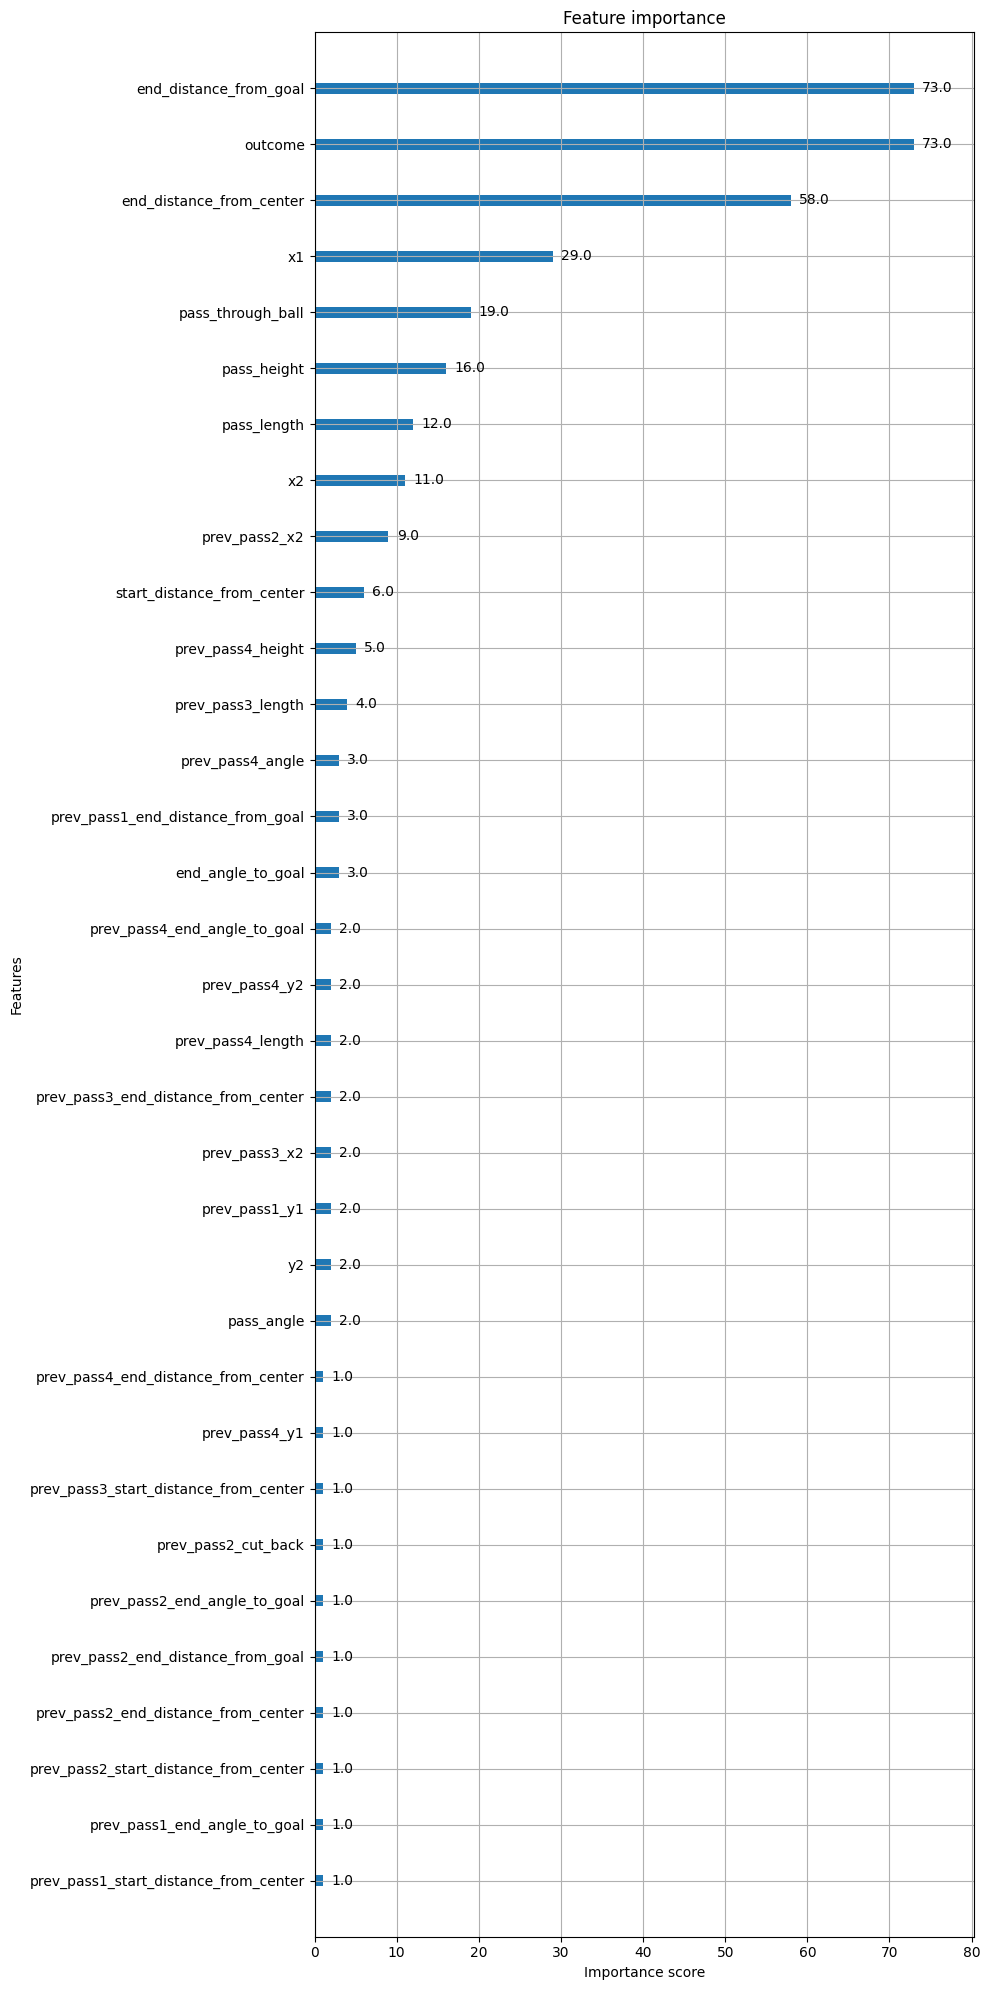

In [81]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model,ax=ax)
plt.tight_layout()
plt.show()